# Processing data
Purpose of this workbook is, given a super folder (which holds .csv files of interest), go through and allow filtering based on tag (using regex)

Then, can take specific subsets of this data to then plot together and allow comparison.

In [1]:
# Import Cell
import sys
sys.path.append('..')
from Utility import process_data_utils as pdu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
from scipy.optimize import curve_fit

In [19]:
# Read in processed csvs
path_sam = "../ProcessedData/2023_11_Organized_Images_SAM_total.csv"
path_ensemble = "../ProcessedData/2023_11_Organized_Images_ensemble_total.csv"

df_sam = pd.read_csv(path_sam)
df_ensemble = pd.read_csv(path_ensemble)

df_master = df_ensemble


/var/folders/vk/znvr66h543g3tt_w4mwmsslh0000gn/T/ipykernel_98070/2692041291.py:5: DtypeWarning: Columns (2,3,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sam = pd.read_csv(path_sam)
/var/folders/vk/znvr66h543g3tt_w4mwmsslh0000gn/T/ipykernel_98070/2692041291.py:6: DtypeWarning: Columns (2,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ensemble = pd.read_csv(path_ensemble)


In [3]:
## Set columns where relevant
df_master[~df_master.pcr.isna()]["search_str"].unique()
df_master[df_master.search_str == "L-3_nM-2.5_au-10_pcr-T_embed-Ag"]

for s in df_master["search_str"].unique():
    if "pcr" in s:
        print(s)



L-3_nM-2.5_au-10_pcr-T_embed-Ag
au60_cube_mixing-F_pcr-T_embed-SiO2
L-3_nM-10_au-10_pcr-T_embed-Ag
au60_oct_mixing-F_pcr-T_embed-SiO2


In [20]:
# Define which parameters you want to set as constant
# Leave out lines you want varied by commenting

sub_df = df_master[
    #    (df_master.L == 4) &
    #    (df_master.concentration == 2.5) &
    #    (df_master.mixing == "T") &
    #    (df_master.oven == "F")
    #    (~df_master.rate.isna())
   ( (df_master.pcr == "T") | ((df_master.mixing == "T")) )
   & (df_master.L == 3.0)
  # & (~df_master.L.isna()) & (df_master.nM == 2.5) & (df_master.mixing == "F")
    #(~df_master.rate.isna())
    #& (df_master.L == 3.0)
        ]
exp_list = np.unique(sub_df.search_str)
num_exp = len(exp_list)
cm_arr = cm.get_cmap('viridis',num_exp)
print(exp_list)


['L-3_nM-10_au-10_pcr-T_embed-Ag'
 'L-3_nM-10_au10_mixing-T_oven-T_embed-Ag'
 'L-3_nM-2.5_au-10_pcr-T_embed-Ag'
 'L-3_nM-3_au10_mixing-T_oven-T_embed-Ag'
 'L-3_nM-3_au10_mixing-T_oven-T_embed-SiO2']


Crystal
9.0 369
Multiple Crystal
9.0 25
Incomplete
9.0 855
Crystal
9.0 79
Multiple Crystal
9.0 8
Incomplete
9.0 207
Crystal
9.0 94
Multiple Crystal
9.0 15
Incomplete
9.0 243
Crystal
9.0 144
Multiple Crystal
9.0 209
Incomplete
9.0 54
Crystal
9.0 267
Multiple Crystal
9.0 258
Incomplete
9.0 276


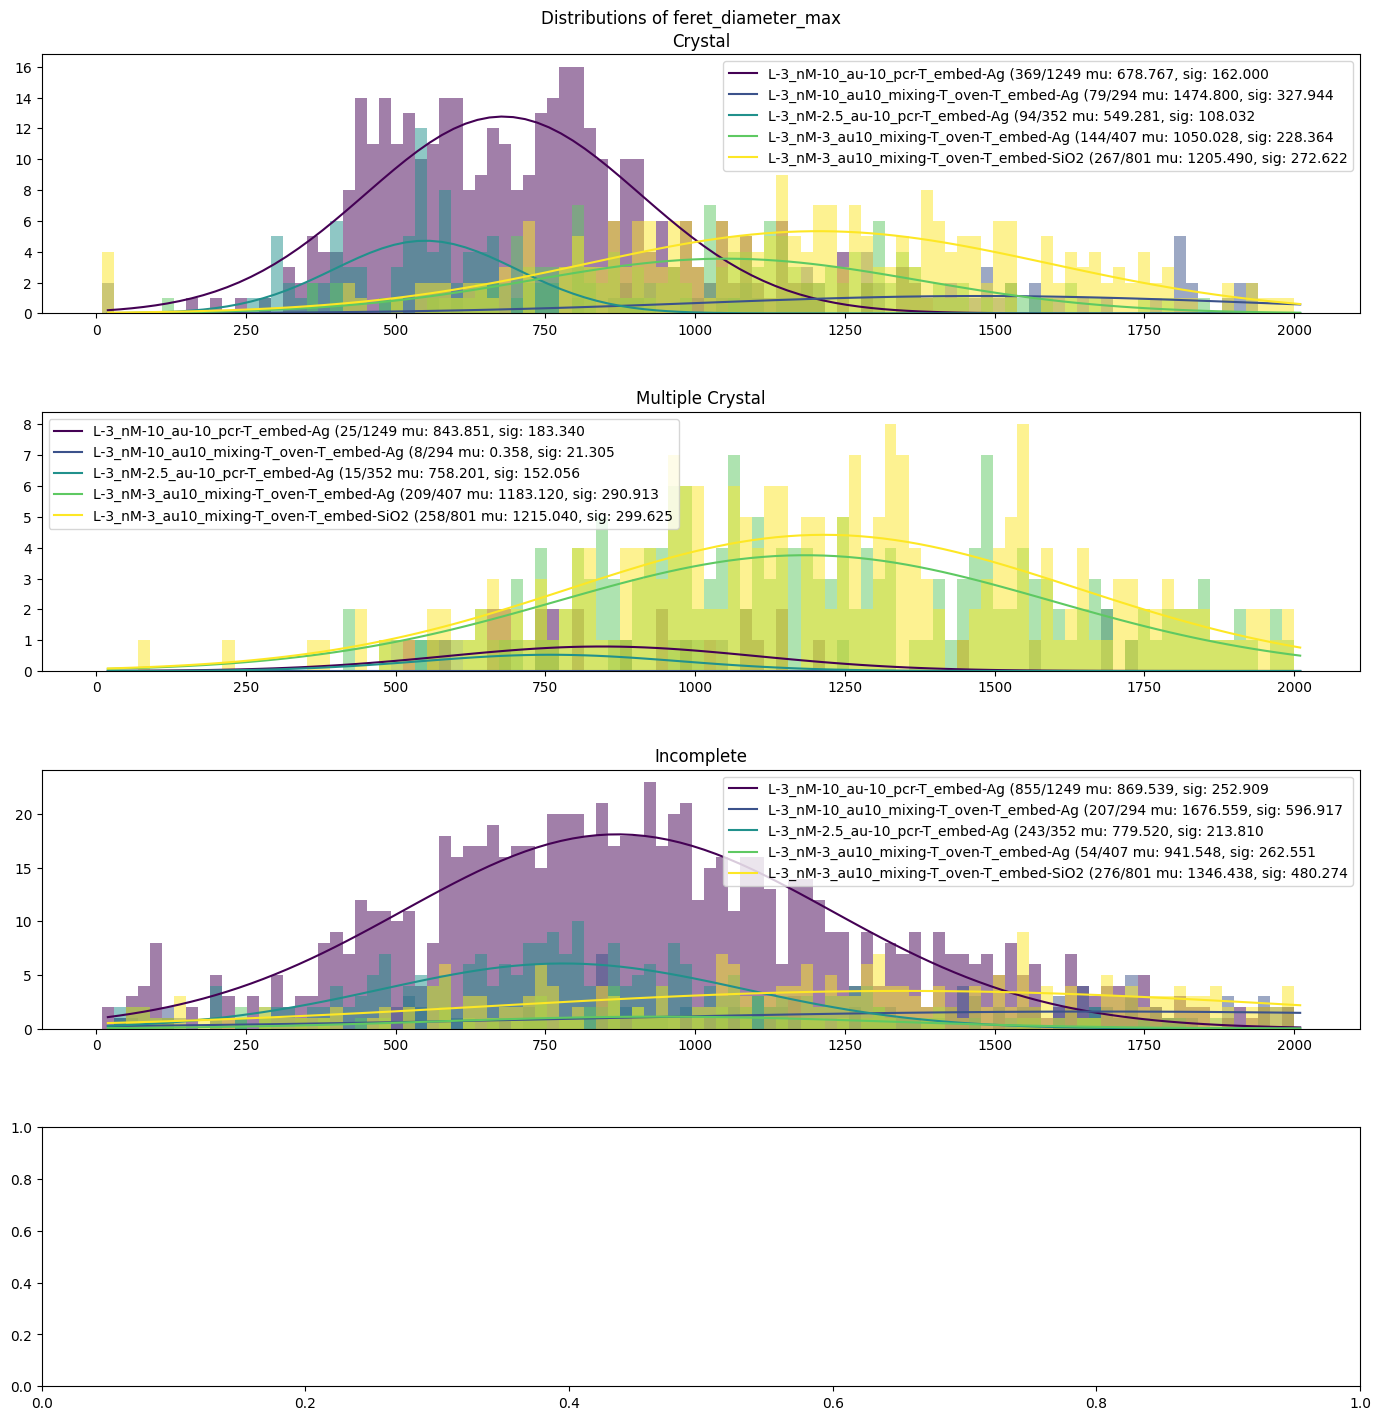

In [21]:
# Gaussian Cell
feature = "feret_diameter_max"
fig_gaussian = pdu.plot_feature_with_experiments_gaussian(df_master,feature,exp_list,color_list=cm_arr.colors)
plt.show(fig_gaussian)

Crystal
88.0 113
Multiple Crystal
88.0 5
Incomplete
88.0 353
Crystal
88.0 94
Multiple Crystal
88.0 23
Incomplete
88.0 124
Crystal
88.0 94
Multiple Crystal
88.0 15
Incomplete
88.0 243
Crystal
88.0 423
Multiple Crystal
88.0 97
Incomplete
88.0 1281


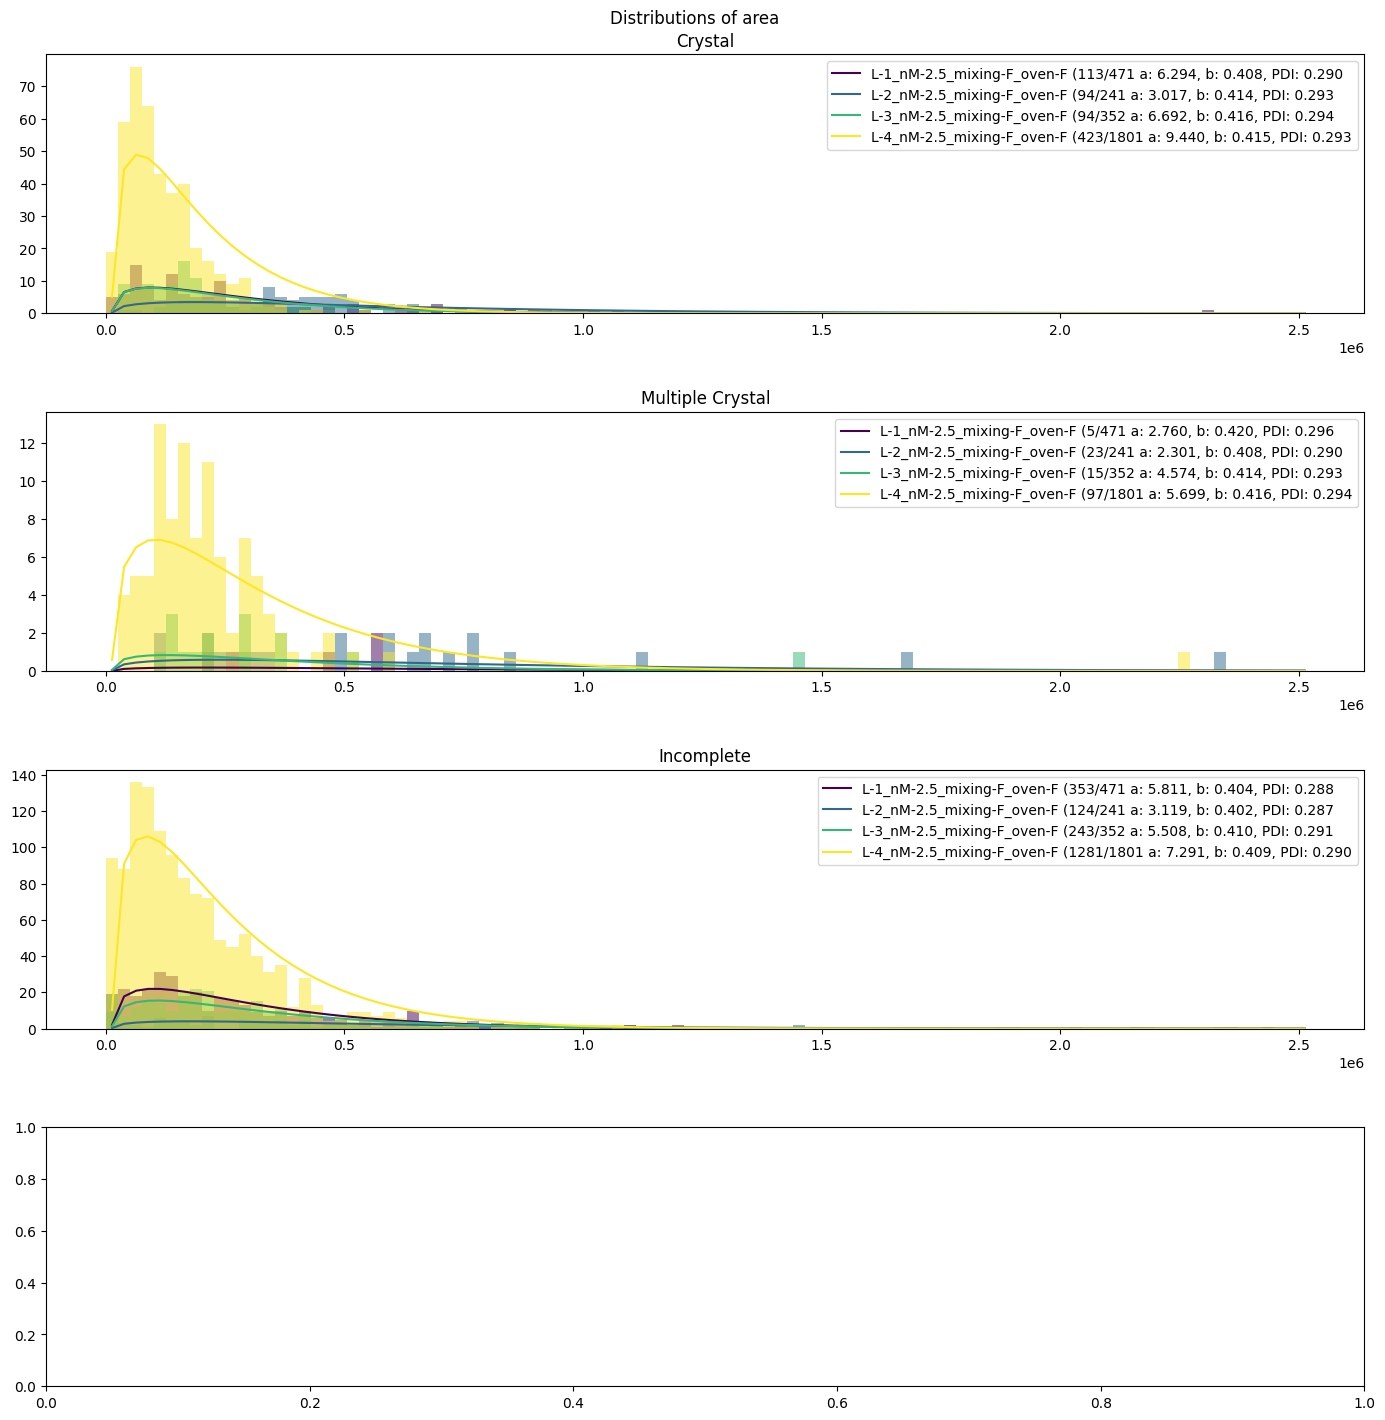

In [6]:
# Schulz Cell
fig_sz = pdu.plot_feature_with_experiments_schultz_zimm(df_master,'area',exp_list,color_list=cm_arr.colors)
plt.show(fig_sz)



In [7]:
## WIP cell for checking out what's going on with Schultz-Zimm
from scipy.optimize import curve_fit
sz = pdu.schultz_zimm
df_oi = pdu.load_dataframe(exp_list[0])
df_oi = df_oi[df_oi["Labels"] == "Crystal"]
fig_oi, ax_oi = plt.subplots()
# COPY PASTING CODE FROM pdu
feature = 'area'
max_out = 2.50*10**6 if feature == 'area' else 2000


histogram_min = df_oi[feature].min()
histogram_max = df_oi[feature].max()
histogram_bins = np.round(np.linspace(histogram_min, max_out,200))


freq = pdu.get_frequency(df_oi,histogram_bins,feature)
scale_factor = 1#counts*histogram_bins[0]
x_bins = histogram_bins #+ (histogram_bins[2]-histogram_bins[1])/2 # Fit to center of bin
prob = np.array(freq)/(np.sum(freq))
popt,pcov = curve_fit(sz,x_bins,prob,
                                  p0=[0,0,1],
                                  bounds=([0.0,0.0,0.5],[50,5,2.1]),
                                  )
a = popt[0]
b = popt[1]
molecular_weight = b/a
molecular_number = (b+1)/a
pdi = molecular_weight/molecular_number


ax_oi.plot(x_bins,sz(histogram_bins,*popt)*scale_factor/np.diff(histogram_bins)[0],color='r')

weights=df_oi[feature]/len(df_oi[feature])
ax_oi.hist(x=df_oi[feature],bins=histogram_bins,color='r',alpha=.5,density=True)
ax_oi.scatter(histogram_bins,prob/np.diff(histogram_bins)[0])

ax_oi.legend()


print(popt)
ax_oi.plot(x_bins,sz(histogram_bins,
                     *[7,.75,.5,1e4])*scale_factor/np.diff(histogram_bins)[0],
                     color='g')


FileNotFoundError: [Errno 2] No such file or directory: '../Results/L-1_nM-2.5_mixing-F_oven-F'

In [ ]:
c1 = 

SyntaxError: invalid syntax (4246105365.py, line 1)